In [1]:
# join Normal density and regression
import numpy as np
from scipy import stats
from scipy.stats import multivariate_normal as mvnorm
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
np.random.seed(1024)

In [3]:
sigma = np.array([2,1,1,3]).reshape(2,2)
mux, muy = 0,0
mu = np.array([mux, muy])
rv = mvnorm(mu, sigma)

In [4]:
sigma_inv = np.linalg.inv(sigma)
sigma_inv

array([[ 0.6, -0.2],
       [-0.2,  0.4]])

In [5]:
# principal component is the largest eigen vector
# eigenvalue decomposition:  sigma = v @ np.diag(w) @ v.T 
# note:  A @ B is matrix product
w, v = np.linalg.eig(sigma)

print(w)
print(v)
(v @ np.diag(w) @ v.T) / sigma  # check

[1.38196601 3.61803399]
[[-0.85065081 -0.52573111]
 [ 0.52573111 -0.85065081]]


array([[1., 1.],
       [1., 1.]])

In [6]:
# eigen vectors
v0 = v[:,0]
v1 = v[:,1]
(v0 @ sigma) / (w[0] * v0)
(v1 @ sigma) / (w[1] * v1) 

array([1., 1.])

In [7]:
np.all((v0 @ v1) == 0)  # v0, v1 are orthogonal

True

In [25]:
def conditional_pdf(x, mux, muy, sigma):
    """pdf(y|x) ~ N(mean, var)"""
    mean = muy + sigma[1,0] /sigma[0,0] * (x - mux)
    var = sigma[1,1] - sigma[1,0] /sigma[0,0] * sigma[0,1]
    return mean, var

def conditional_mean(u, mux, muy, sigma, option = 'y|x'):
    """ E(y|x) or E(x|y: regression in bivariate normal"""
    sig_xx = sigma[0,0]
    sig_yy = sigma[1,1]
    sig_xy = sigma[0,1]
    sig_yx = sigma[1,0]
    if option == 'x|y':
        fit = mux + sig_xy / sig_yy * (u - muy)
    else:
        fit = muy + sig_yx / sig_xx * (u - mux)

    return fit

In [26]:
sigma

array([[2, 1],
       [1, 3]])

In [27]:
# conditional_pdf(1, 0, 0, sigma)
gridx = np.arange(-3, 4)
[conditional_mean(u, 0, 0, sigma) for u in gridx]

[-1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5]

In [28]:
[conditional_mean(1,0,0,sigma, 'y|x'), conditional_mean(1,0,0,sigma, 'x|y')]

[0.5, 0.3333333333333333]

In [29]:
x, y = np.mgrid[-6:6:.01, -6:6:.01]
pos = np.empty(x.shape + (2,)) 
pos[:,:,0] = x
pos[:,:,1] = y

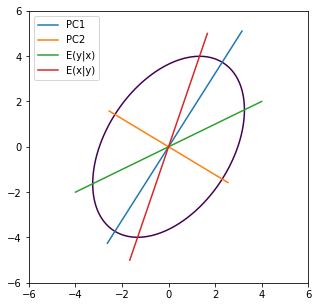

In [32]:
# plot x,y in same scale to demonstrate the othrogonality of the two principal components
plt.figure(figsize=(5,5))  
plt.contour(x,y, rv.pdf(pos), [.005])

# regression line y|x = m(x)
gridx = np.arange(-4,5)
fity = [conditional_mean(u, mux, muy, sigma, 'y|x') for u in gridx]

# regression line x/y = m(y)
gridy = np.arange(-5,6)
fitx = [conditional_mean(u, mux, muy, sigma, 'x|y') for u in gridy]

# principal component 1,2 (order by eigen value)
xy1 = np.array([v1 * u + [mux, muy] for u in np.arange(-6,6)])
xy0 = np.array([v0 * u + [mux, muy] for u in np.arange(-3,4)])


plt.plot(xy1[:,0], xy1[:,1])
plt.plot(xy0[:,0], xy0[:,1])
plt.plot(gridx, fity)
plt.plot(fitx, gridy)
plt.legend(['PC1', 'PC2', 'E(y|x)', 'E(x|y)'])

plt.show()

In [14]:
rv = mvnorm(mu, sigma)
sim_data = rv.rvs(200)
slope, intercept,_,_,_ = stats.linregress(sim_data)
# stats.linregress(a[:,0], a[:,1])
[slope, intercept]

[0.548135637704147, -0.08594690793260833]

In [15]:
stats.linregress(sim_data)

LinregressResult(slope=0.548135637704147, intercept=-0.08594690793260833, rvalue=0.49526253477366855, pvalue=8.95974234049638e-14, stderr=0.0683300069760652)

In [16]:
sigma_bar = np.cov(sim_data.T)
xbar, ybar = np.mean(sim_data, axis=0)
[xbar, ybar]

[-0.023342565723999276, -0.09874180008138365]

In [17]:
# lsfit y = a + bx and E(y|x) from pdf should agree.
[slope, conditional_mean(1, 0, 0, np.cov(sim_data.T))]

[0.548135637704147, 0.5481356377041472]

In [18]:
np.linalg.eig(sigma_bar)

(array([1.29333596, 3.91111347]), array([[-0.77491143, -0.63206983],
        [ 0.63206983, -0.77491143]]))

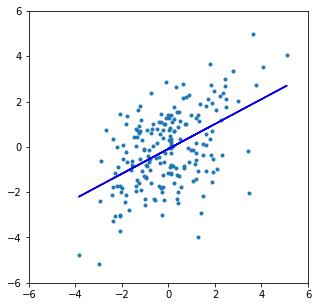

In [19]:
yfit_ls = [slope * u + intercept for u in sim_data[:,0]]
yfit_pdf = [conditional_mean(u,xbar,ybar,sigma_bar) for u in sim_data[:,0]]
#
plt.figure(figsize = (5,5))
plt.xlim(-6,6)
plt.ylim(-6,6)
plt.plot(sim_data[:,0], sim_data[:,1], '.')
plt.plot(sim_data[:,0], yfit_ls)
plt.plot(sim_data[:,0], yfit_pdf, 'b')

In [20]:
np.cov(sim_data[:,0], sim_data[:,1])

array([[2.33917021, 1.28218255],
       [1.28218255, 2.86527922]])

In [21]:
# try sklearn
from sklearn.linear_model import LinearRegression as LR

In [22]:
x = sim_data[:,0]
y = sim_data[:,1]
model = LR()
model.fit(x[:, np.newaxis], y)
xfit = np.linspace(-4,4, 100)
yfit = model.predict(xfit[:,np.newaxis])
[model.coef_[0], model.intercept_, slope, intercept]

[0.5481356377041472,
 -0.08594690793260831,
 0.548135637704147,
 -0.08594690793260833]

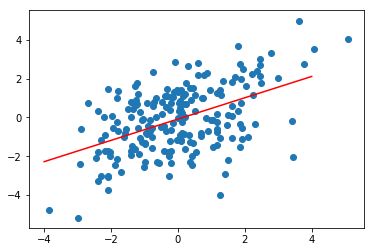

In [23]:
plt.scatter(x,y)
plt.plot(xfit, yfit, 'r')
plt.show()